A slightly class-ier version.  Hopefully this'll be the last 'generation' of notebook for this.  Anyone who's good at Python code reviews please follow along and give feedback :)

The plan is to document things *a lot* better as I go along and put things in a nice OO (and closer to PEP8) style.

The current biggest challenge is getting enough time to do this right :P

In [1]:
from base64 import b64encode
import copy
from datetime import datetime
import getopt
from io import BytesIO
import os
import sys

# standard numeric/scientific libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('figure', figsize=(20, 12))

# image display
from PIL import Image
import IPython.display 
from IPython.display import HTML

#internal libraries which may or may not get used
import fdls

Helper/graphing functions.  This will be broken out into it's own .py file once done.

In [2]:
# charting/graphing code carried over from earlier development efforts
# (will probably be moved back into a ldutils2 package)

def todb(y, zero = False):
    db = 20 * np.log10(np.abs(y))
    if zero:
        return db - np.max(db)
    else:
        return db

def plotfilter_wh(w, h, freq, zero_base = False):
    db = todb(h, zero_base)
    
    above_m3 = None
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i]) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i])
            above_m3 = i
        if (db[i] < -3) and (db[i - 1] >= -3):
            if above_m3 is not None:
                peak_index = np.argmax(db[above_m3:i]) + above_m3
                print("peak at ", w[peak_index], db[peak_index])
            print("<-3db crossing at ", w[i]) 
        if (db[i] >= 3) and (db[i - 1] < 3):
            print(">3db crossing at ", w[i]) 
    
    fig, ax1 = plt.subplots(1, 1, sharex=True)
    ax1.set_title('Digital filter frequency response')

    ax1.plot(w, db, 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()
    
    return None

def plotfilter(B, A, freq = 40, whole = False, zero_base = False):
    w, h = sps.freqz(B, A, whole = whole, worN=4096)
    
    if whole:
        w = np.arange(0, freq, freq / len(h))
    else:
        w = np.arange(0, (freq / 2), (freq / 2) / len(h))
        
    return plotfilter_wh(w, h, freq, zero_base)

# Draws a uint16 image, downscaled to uint8
def draw_raw_bwimage(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [3]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]
    
def downscale_field(data, lineinfo, outwidth=1820, lines=625):
    ilinepx = linelen
    dsout = np.zeros((len(lineinfo) * outwidth), dtype=np.double)    

    sfactor = [None]

    for l in range(1, 262):
        scaled = scale(data, lineinfo[l], lineinfo[l + 1], outwidth)
        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / outwidth)

        wow = (lineinfo[l + 1] - lineinfo[l]) / linelen
        #wow = None
        
        if wow is not None:
            scaled /= wow
        dsout[l * outwidth:(l + 1)*outwidth] = scaled
        
    return dsout, sfactor


For this part of the loader phase I found myself going to function objects that implement this sample API:

```
infile: standard readable/seekable python binary file
sample: starting sample #
readlen: # of samples
```
Returns data if successful, or None or an upstream exception if not (including if not enough data is available)

This might probably need to become a full object once FLAC support is added.

In [4]:

def load_unpacked_data(infile, sample, readlen, sampletype):
    # this is run for unpacked data - 1 is for old cxadc data, 2 for 16bit DD
    infile.seek(sample * sampletype, 0)
    inbuf = infile.read(readlen * sampletype)

    if sampletype == 2:
        indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
    else:
        indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
    return indata

def load_unpacked_data_u8(infile, sample, readlen):
    return load_unpacked_data(infile, sample, readlen, 1)

def load_unpacked_data_s16(infile, sample, readlen):
    return load_unpacked_data(infile, sample, readlen, 2)

# This is for the .r30 format I did in ddpack/unpack.c.  Depricated but I still have samples in it.
def load_packed_data_3_32(infile, sample, readlen):
    start = (sample // 3) * 4
    offset = sample % 3
    start, offset

    infile.seek(start)

    # we need another word in case offset != 0
    needed = int(np.ceil(readlen * 3 / 4) * 4) + 4

    inbuf = infile.read(needed)
    indata = np.fromstring(inbuf, 'uint32', len(inbuf) // 4)

    unpacked = np.zeros(len(indata) * 3, dtype=np.int16)

    # By using strides the unpacked data can be loaded with no additional copies
    np.bitwise_and(indata, 0x3ff, out = unpacked[0::3])
    # hold the shifted bits in it's own array to avoid an allocation
    tmp = np.right_shift(indata, 10)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[1::3])
    np.right_shift(indata, 20, out = tmp)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[2::3])

    return unpacked[offset:offset + readlen]


# The 10-bit samples from the Duplicator...

'''
From Simon's code:

// Original
// 0: xxxx xx00 0000 0000
// 1: xxxx xx11 1111 1111
// 2: xxxx xx22 2222 2222
// 3: xxxx xx33 3333 3333
//
// Packed:
// 0: 0000 0000 0011 1111
// 2: 1111 2222 2222 2233
// 4: 3333 3333
'''

# The bit twiddling is a bit more complex than I'd like... but eh.  I think
# it's debugged now. ;)
def load_packed_data_4_40(infile, sample, readlen):
    start = (sample // 4) * 5
    offset = sample % 4

    seekedto = infile.seek(start)
    
    # we need another word in case offset != 0
    needed = int(np.ceil(readlen * 5 // 4)) + 5

    inbuf = infile.read(needed)
    indata = np.frombuffer(inbuf, 'uint8', len(inbuf))

    rot2 = np.right_shift(indata, 2)

    unpacked = np.zeros(readlen + 4, dtype=np.uint16)

    # we need to load the 8-bit data into the 16-bit unpacked for left_shift to work
    # correctly...
    unpacked[0::4] = indata[0::5]
    np.left_shift(unpacked[0::4], 2, out=unpacked[0::4])
    np.bitwise_or(unpacked[0::4], np.bitwise_and(np.right_shift(indata[1::5], 6), 0x03), out=unpacked[0::4])

    unpacked[1::4] = np.bitwise_and(indata[1::5], 0x3f)
    np.left_shift(unpacked[1::4], 4, out=unpacked[1::4])
    np.bitwise_or(unpacked[1::4], np.bitwise_and(np.right_shift(indata[2::5], 4), 0x0f), out=unpacked[1::4])

    unpacked[2::4] = np.bitwise_and(indata[2::5], 0x0f)
    np.left_shift(unpacked[2::4], 6, out=unpacked[2::4])
    np.bitwise_or(unpacked[2::4], np.bitwise_and(np.right_shift(indata[3::5], 2), 0x3f), out=unpacked[2::4])

    unpacked[3::4] = np.bitwise_and(indata[3::5], 0x03)
    np.left_shift(unpacked[3::4], 8, out=unpacked[3::4])
    np.bitwise_or(unpacked[3::4], indata[4::5], out=unpacked[3::4])

    return unpacked[offset:offset + readlen]



In [5]:
# Essential standalone routines 

pi = np.pi
tau = np.pi * 2

#https://stackoverflow.com/questions/20924085/python-conversion-between-coordinates
polar2z = lambda r,θ: r * np.exp( 1j * θ )
deg2rad = lambda θ: θ * (np.pi / 180)

# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html

# hilbert_filter_terms has a direct impact on filter delays.  Emperical testing
# determined that 128 was a good value here.
hilbert_filter_terms = 128
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*hilbert_filter_terms+[0]*hilbert_filter_terms)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do a good chunk of real demoduation work
#fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

# This converts a regular B, A filter to an FFT of our selected block length
def filtfft(filt, blocklen):
    return sps.freqz(filt[0], filt[1], blocklen, whole=1)[1]

In [6]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

In [7]:
def calczc(data, _start_offset, target, edge='both', reverse=False, _count=10):
    start_offset = int(_start_offset)
    count = int(_count + 1)
    
    if edge == 'both': # capture rising or falling edge
        if data[start_offset] < target:
            edge = 'rising'
        else:
            edge = 'falling'

    if edge == 'rising':
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
               
    if len(locs) == 0:
        return None

    if reverse:
        index = -1
    else:
        index = 0
        
    x = start_offset + locs[index] #+ offset
    
    if (x == 0):
        #print("BUG:  cannot figure out zero crossing for beginning of data")
        return None
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [8]:
def unwrap_hilbert(hilbert, freq_hz):
    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    return (tdangles2 * (freq_hz / tau))

In [9]:
# These are invariant parameters 
SysParams_NTSC = {
    'fsc_mhz': (315.0 / 88.0),
    'pilot_mhz': (315.0 / 88.0),
    'frame_lines': 525,

    'ire0': 8100000,
    'hz_ire': 1700000 / 140.0,

    # most NTSC disks have analog audio, except CD-V and a few Panasonic demos
    'analog_audio': True,
    # From the spec - audio frequencies are multiples of the (color) line rate
    'audio_lfreq': (1000000*315/88/227.5) * 146.25,
    'audio_rfreq': (1000000*315/88/227.5) * 178.75,
}

# In color NTSC, the line period was changed from 63.5 to 227.5 color cycles,
# which works out to 63.5(with a bar on top) usec
SysParams_NTSC['line_period'] = 1/(SysParams_NTSC['fsc_mhz']/227.5)


In [10]:
SysParams_NTSC['fsc_mhz']

3.5795454545454546

In [11]:
class RFDecode:
    def __init__(self, freq = 40, system = 'NTSC', blocklen_ = 16384):
        self.blocklen = blocklen_
        self.blockcut = 512 # ???
        self.system = system
        
        self.freq = freq
        self.freq_half = freq / 2
        self.freq_hz = self.freq * 1000000
        self.freq_hz_half = self.freq * 1000000 / 2
        
        if system == 'NTSC':
            self.SysParams = SysParams_NTSC
                
            self.DecoderParams = {
                # The audio notch filters are important with DD v3.0+ boards
                'audio_notchwidth': 350000,
                'audio_notchorder': 2,

                # (note:  i don't know how to handle these values perfectly yet!)
                'video_deemp': (120*.32, 320*.32), # On some captures this is as low as .55.

                # This BPF similar but not *quite* identical to what Pioneer did
                'video_bpf': [3500000, 13200000],
                'video_bpf_order': 3,

                # This can easily be pushed up to 4.5mhz or even a bit higher. 
                # A sharp 4.8-5.0 is probably the maximum before the audio carriers bleed into 0IRE.
                'video_lpf_freq': 4200000,   # in mhz
                'video_lpf_order': 5 # butterworth filter order
            }
            
            self.Filters = {
                'MTF': sps.zpk2tf([], [polar2z(.7,np.pi*12.5/20), polar2z(.7,np.pi*27.5/20)], 1.11)
            }

            
        self.computefilters()
            
    def computefilters(self):
        self.Filters = {}
        
        # Use some shorthand to compact the code.  good idea?  prolly not.
        SF = self.Filters
        SP = self.SysParams
        DP = self.DecoderParams
        
        SF['hilbert'] = np.fft.fft(hilbert_filter, self.blocklen)
        
        filt_rfvideo = sps.butter(DP['video_bpf_order'], [DP['video_bpf'][0]/self.freq_hz_half, DP['video_bpf'][1]/self.freq_hz_half], btype='bandpass')
        SF['RFVideo'] = filtfft(filt_rfvideo, self.blocklen)

        if SP['analog_audio']: 
            cut_left = sps.butter(DP['audio_notchorder'], [(SP['audio_lfreq'] - DP['audio_notchwidth'])/self.freq_hz_half, (SP['audio_lfreq'] + DP['audio_notchwidth'])/self.freq_hz_half], btype='bandstop')
            SF['Fcutl'] = filtfft(cut_left, self.blocklen)
            cut_right = sps.butter(DP['audio_notchorder'], [(SP['audio_rfreq'] - DP['audio_notchwidth'])/self.freq_hz_half, (SP['audio_rfreq'] + DP['audio_notchwidth'])/self.freq_hz_half], btype='bandstop')
            SF['Fcutr'] = filtfft(cut_right, self.blocklen)
        
            SF['RFVideo'] *= (SF['Fcutl'] * SF['Fcutr'])
            
        SF['RFVideo'] *= SF['hilbert']
        
        video_lpf = sps.butter(DP['video_lpf_order'], DP['video_lpf_freq']/self.freq_hz_half, 'low')
        SF['Fvideo_lpf'] = filtfft(video_lpf, self.blocklen)

        # The deemphasis filter.  This math is probably still quite wrong, but with the right values it works
        deemp0, deemp1 = DP['video_deemp']
        [tf_b, tf_a] = sps.zpk2tf(-deemp1*(10**-10), -deemp0*(10**-10), deemp0 / deemp1)
        SF['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/self.freq_hz_half), self.blocklen)

        # The direct opposite of the above, used in test signal generation
        [tf_b, tf_a] = sps.zpk2tf(-deemp0*(10**-10), -deemp1*(10**-10), deemp1 / deemp0)
        SF['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/self.freq_hz_half), self.blocklen)
        
        # Post processing:  lowpass filter + deemp
        SF['FVideo'] = SF['Fvideo_lpf'] * SF['Fdeemp'] 
    
        # additional filters:  0.5mhz and color burst
        # Using an FIR filter here to get tighter alignment
        F0_5 = sps.firwin(65, [0.5/self.freq_half], pass_zero=True)
        SF['F0_5'] = filtfft((F0_5, [1.0]), self.blocklen)
        SF['FVideo05'] = SF['Fvideo_lpf'] * SF['Fdeemp']  * SF['F0_5']

        if self.system == 'NTSC':
            SF['Fburst_len'] = int(np.ceil((18 * self.freq_half / SP['fsc_mhz']) / 2) * 2)
            SF['Fburst_delay'] = SF['Fburst_len'] // 2
            bf = sps.firwin(SF['Fburst_len'] + 1, [(SP['fsc_mhz'] * .975)/self.freq_half, (SP['fsc_mhz'] * 1.025)/self.freq_half], pass_zero=False)
            SF['Fburst'] = filtfft((bf, [1.0]), self.blocklen)
            SP['Fburst'] = filtfft(sps.butter(1, [(SP['fsc_mhz']-.1)/self.freq_half, (SP['fsc_mhz']+.1)/self.freq_half], btype='bandpass'), self.blocklen) 
            SF['imglen'] = (int)((self.freq_hz / 59.976) * 1.25)
        else:
            # For PAL this is a 3.75mhz filter
            SP['Fburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
            SP['imglen'] = (int)((SP['freq_hz'] / 50) * 1.25)
        
        SF['FVideoBurst'] = SF['Fvideo_lpf'] * SF['Fdeemp']  * SF['Fburst']
        
        # emperical work determined that a single-pole low frequency filter effectively 
        # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
        f = sps.butter(1, 0.05/self.freq_half, btype='low')
        SF['FPsync'] = filtfft(f, self.blocklen)
        
    def iretohz(self, ire):
        return self.SysParams['ire0'] + (self.SysParams['hz_ire'] * ire)

    def hztoire(self, hz):
        return (hz - self.SysParams['ire0']) / self.SysParams['hz_ire']
    
    def demodblock(self, data, mtf_level = 0):
        indata_fft = np.fft.fft(data[:self.blocklen])
        indata_fft_filt = indata_fft * self.Filters['RFVideo']

        if mtf_level != 0:
            indata_fft_filt *= self.Filters['MTF'] ** mtf_level

        hilbert = np.fft.ifft(indata_fft_filt)
        demod = unwrap_hilbert(hilbert, self.freq_hz)

        demod_fft = np.fft.fft(demod)

        out_video = np.fft.ifft(demod_fft * self.Filters['FVideo']).real
        out_video05 = np.fft.ifft(demod_fft * self.Filters['FVideo05']).real
        out_videoburst = np.fft.ifft(demod_fft * self.Filters['FVideoBurst']).real
        
        if self.system == 'PAL':
            out_videopilot = np.fft.ifft(demod_fft * self.Filters['FVideoPilot']).real

        # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
        output_sync = inrange(out_video05, self.iretohz(-55), self.iretohz(-25))
        # Perform FFT convolution of above filter
        output_syncf = np.fft.ifft(np.fft.fft(output_sync) * self.Filters['FPsync']).real
        
        if self.system == 'PAL':
            out_videopilot = np.fft.ifft(demod_fft * paramsc['FVideoPilot']).real

            rv_video = np.rec.array([out_video, out_video05, output_syncf, out_videoburst, out_videopilot], names=['demod', 'demod_05', 'demod_sync', 'demod_burst', 'demod_pilot'])
        else:
            rv_video = np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])

        if True or params['analog_audio'] == False:
            return rv_video, None

        # Audio section
        hilbert = np.fft.ifft(audio_fdslice(paramsc, indata_fft) * paramsc['audio_lfilt'])
        audio_left = unwrap_hilbert(hilbert, paramsc['freq_arf']) + paramsc['audio_lowfreq']

        hilbert = np.fft.ifft(audio_fdslice(paramsc, indata_fft) * paramsc['audio_rfilt'])
        audio_right = unwrap_hilbert(hilbert, paramsc['freq_arf']) + paramsc['audio_lowfreq']

        rv_audio = np.rec.array([audio_left, audio_right], names=['audio_left', 'audio_right'])

        return rv_video, rv_audio

    def demod(self, infile, start, length):
        end = int(start + length) + 1

        if (start > self.blockcut):
            start = int(start - self.blockcut)
        else:
            start = 0 # should this be an error?  prolly.

        # set a placeholder
        output = None
        output_audio = None

        for i in range(start, end, self.blocklen - self.blockcut):
            indata = loader(infile, i, self.blocklen)
            if indata is None:
                break

            tmp_video, tmp_audio = self.demodblock(indata)

            # if the output hasn't been created yet, do it now using the 
            # data types returned by dodemod (should be faster than multiple
            # allocations...)
            if output is None:
                output = np.zeros(end - start + 1, dtype=tmp_video.dtype)

            if i - start + (self.blocklen - self.blockcut) > len(output):
                copylen = len(output) - (i - start)
            else:
                copylen = self.blocklen - self.blockcut

            output_slice = slice(i - start, i - start + copylen)
            tmp_slice = slice(self.blockcut, self.blockcut + copylen)

            output[output_slice] = tmp_video[tmp_slice]

            # repeat the above - but for audio
            if tmp_audio is not None:
                audio_downscale = tmp_video.shape[0] // tmp_audio.shape[0]

                if output_audio is None:
                    output_audio = np.zeros(((end - start) // audio_downscale) + 1, dtype=tmp_audio.dtype)

                output_slice = slice((i - start) // audio_downscale, (i - start + copylen) // audio_downscale)
                tmp_slice = slice(self.blockcut // audio_downscale, (self.blockcut + copylen) // audio_downscale)

                output_audio[output_slice] = tmp_audio[tmp_slice]

        return output, output_audio


In [12]:
SysParams = copy.deepcopy(SysParams_NTSC)

In [13]:
linelen = 40000000/(1000000/SysParams['line_period'])
linelen = int(np.round(linelen))
linelen

2542

In [14]:
def get_syncpeaks(data, start):
    # This is done as a while loop so each peak lookup is aligned to the previous one
    ds = data[0]['demod_sync']

    peaklist = []

    i = start
    while i < (len(ds) - linelen):
        peakloc = np.argmax(ds[i:i + (linelen//2)]) #+ start
        peak = ds[i + peakloc]

        if peak > .2:
            #print(i + peakloc, peak)

            # TODO: validity check for lack of rot goes here?

            # TODO: Work out adjustments for NTSC and PAL automagically
            lineloc = i + peakloc + 0

            peaklist.append(lineloc)

            # This allows all peaks to get caught properly
            i += peakloc + int(linelen * .4)
        else: # nothing valid found - keep looking!
            i += linelen // 2

    return peaklist

In [15]:
def determine_field(data, peaklist, peaknum):
    if peaknum < 11:
        return None
    
    ds = data[0]['demod_sync']    
    
    # Determine first/second field
    # should this rely on what comes *after* the vsync too?
    line0 = None
    for i in range(peaknum - 1, peaknum - 10, -1):
        peak = ds[peaklist[i]]
        prevpeak = ds[peaklist[i + 1]]

        if peak > .6 and line0 is None:
            line0 = i

    return line0, (peaklist[line0 + 1] - peaklist[line0]) > (linelen * .75)     
        
#is_fieldtwo = (peaklist[line0 + 1] - peaklist[line0]) < (linelen * .75)    
def determine_vsyncs(data, peaklist):
    # find vsyncs from the peaklist
    ds = data[0]['demod_sync']
    vsyncs = []

    prevpeak = 1.0
    for i, p in enumerate(peaklist):
        peak = ds[p]
        if peak > .8 and prevpeak < .6:
            vsyncs.append((i, *determine_field(data, peaklist, i)))

        prevpeak = peak
        
    return vsyncs

In [16]:
def compute_linelocs(peaklist, vsyncs):
    # Build actual line positions, skipping half-lines and adding padding as needed
    linelocs = [peaklist[vsyncs[0][1]]]

    for curindex in range(vsyncs[0][1] + 1, vsyncs[1][0] - 5):
        curline = peaklist[curindex]
        #print(curline)

        if (curline - linelocs[-1]) > (linelen * 1.05):
            linelocs.append(linelocs[-1] + linelen)
        elif (curline - linelocs[-1]) > (linelen * .95):
            linelocs.append(curline)

    return linelocs

In [183]:
def refine_linelocs_hsync(data, linelocs):
    offset = 400 # XXX: change to computed value
    # Adjust linelocs to beginning of HSYNC

    linelocs2 = linelocs.copy()
    for i in range(len(linelocs)):
        # First adjust the lineloc before the beginning of hsync - 
        # lines 1-9 are half-lines which need a smaller offset
        if i > 9:
            linelocs2[i] -= offset
        else:
            linelocs2[i] -= 200

        err = False
        
        zc = calczc(data[0]['demod_05'], linelocs2[i], rfd.iretohz(-20), reverse=False, _count=400) - 32
        #print(i, linelocs2[i], zc)
        if zc is not None:
            linelocs2[i] = zc
            
            origdata = data[0]['demod'][int(zc)-40:int(zc)+100]
            #(data[0]['demod'][int(zc)-100:int(zc)+20], rfd.iretohz(-50), rfd.iretohz(30)))
            if np.min(origdata) < rfd.iretohz(-50):
                err = True
        else:
            err = True
            
            
        if i > 10 and err:
            gap = linelocs2[i - 1] - linelocs2[i - 2]
            linelocs2[i] = linelocs2[i - 1] + gap
            print(i, zc, linelocs2[i])
    
    return linelocs2

33 93544.34951991758 93707.00761147501
35 98785.4199942469 98784.9740888906
46 126718.14996259096 126718.44338530248
57 154659.21018847238 154658.67880020646
60 162281.569477399 162280.98646346043
72 192777.73147392264 192777.46721130205
77 205489.53241941606 205488.8493501353
88 233315.09524875908 233462.59265503977
129 337809.55486245616 337809.99826281203
142 370906.0669865174 370905.129134775
146 380921.1359301458 381091.2361309126
183 475103.7945221147 475324.8751038882
186 482965.2803638759 482965.4458088576
187 485512.53908996144 485512.4879934157
191 495701.2942681222 495701.12900459336
208 538787.4099077808 539000.2506452453
209 541547.6501207352 541547.4693386847
213 551515.8969062765 551736.9009052109
215 556831.041292997 556830.2036083428
220 569375.1851132283 569568.1816162604
231 597589.8653566074 597589.9039405704
232 600137.1740031465 600137.155490836
233 602685.1937642151 602684.4070411016
238 615231.8619067075 615421.1776526658
263 679099.0811836527 679099.2340002181


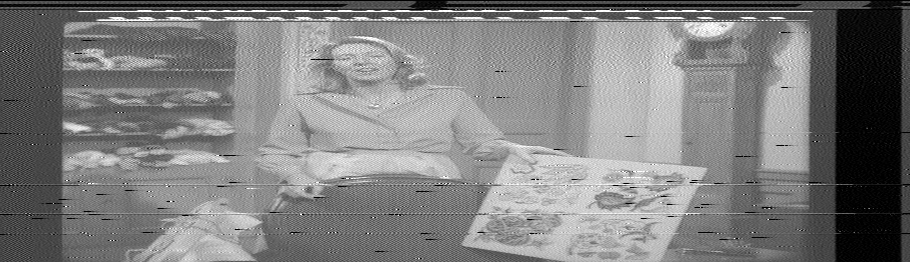

In [184]:
linelocs1 = compute_linelocs(peaklist, vsyncs)
linelocs2 = refine_linelocs_hsync(decode1, linelocs1)
linelocs3, burstlevels3 = refine_linelocs_ntscburst(decode1, linelocs2)

decoded_field, outlinelen = downscale_ntsc_field(decode1, linelocs1)
reduced = (decoded_field[0] - rfd.iretohz(-40)) / SysParams['hz_ire']
lines16 = np.uint16(np.clip(reduced * (65535 / 140), 0, 65535) + 0.5)

draw_raw_bwimage(lines16, outlinelen, 262, hscale=1, vscale=1)

In [185]:
rfd.iretohz(10)

8221428.571428572

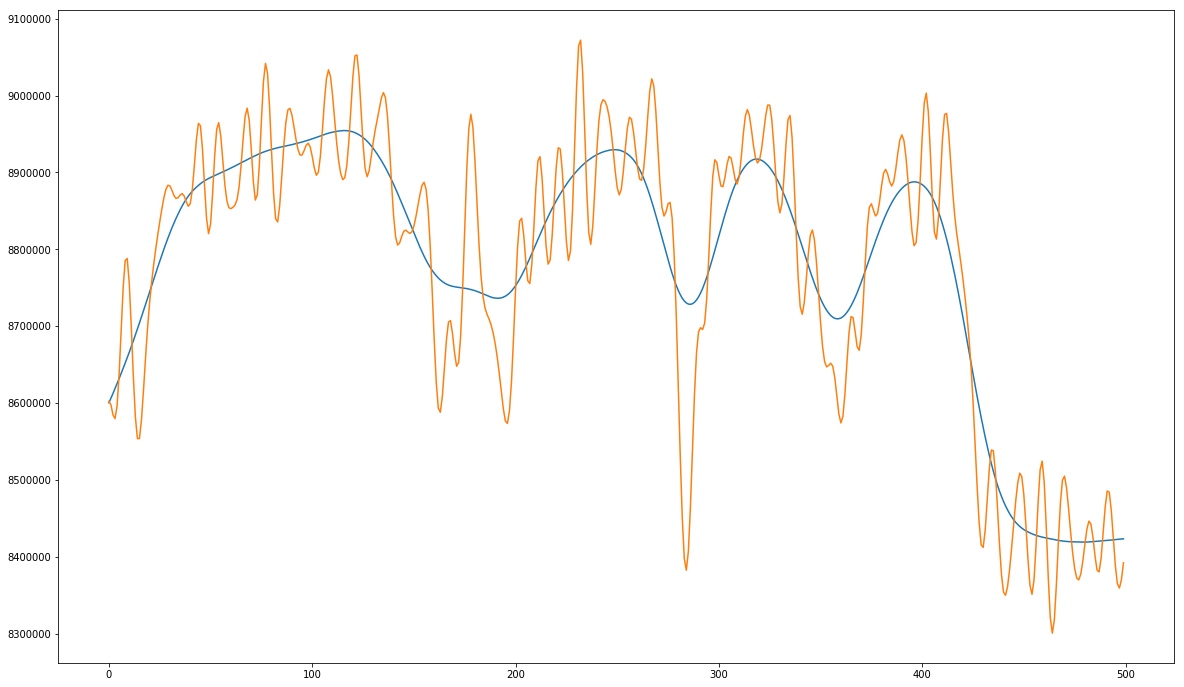

In [186]:
d = decode1[0]['demod_05']
plt.plot(d[609449+32:609949+32])
d = decode1[0]['demod']
plt.plot(d[609449:609949])

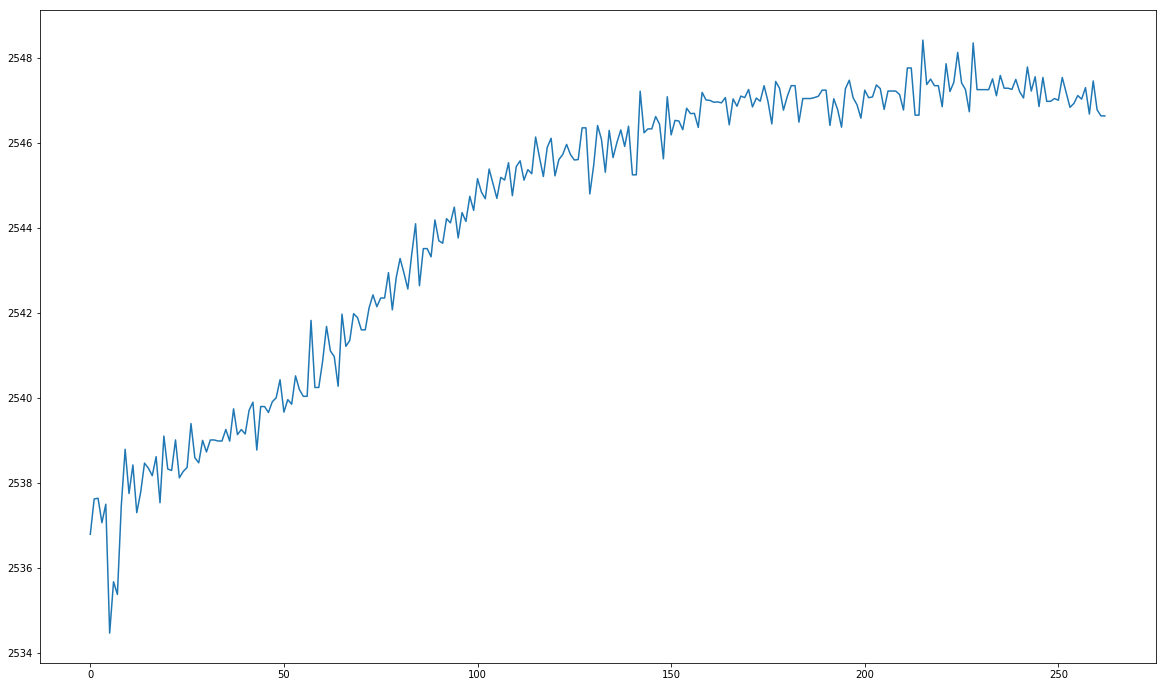

In [187]:
plt.plot(np.diff(linelocs2))

In [188]:
# returns an NTSC 4fsc bitmap of desired channel
def downscale_ntsc_field(data, linelocs, channel = 'demod'):
    outlinelen = (4 * 1000000 * 315 / 88) / (1000000/SysParams['line_period'])
    outlinelen = int(np.round(outlinelen))

    return downscale_field(data[0][channel], linelocs, outwidth=outlinelen), outlinelen

In [189]:
shift33 = -((33.0 / 360.0) * np.pi)

def refine_linelocs_ntscburst(data, linelocs2, phaseoffset = False):
    scaledburst, outlinelen = downscale_ntsc_field(data, linelocs2, 'demod_burst')

    linelocs3 = linelocs2.copy()
    zcs = [None] * len(linelocs2) # linelocs2.copy()
    burstlevel = np.zeros_like(linelocs3, dtype=np.float32)

    # Compute the zero crossings first, and then determine if 
    # alignment should be to the nearest odd/even pixel.  Having a 2px
    # granularity seems to help (single frame) quality but may have issues
    # later on... :P
    
    even = 0 
    odd = 0
    oddalign = 0

    for l in range(len(linelocs2)):
        ba = scaledburst[0][outlinelen*l:outlinelen*(l+0)+125].copy()
        ba -= np.mean(ba)
        
        m = np.argmax(np.abs(ba))
        burstlevel[l] = np.abs(ba[m])
        
        
        zcs[l] = calczc(ba, m, 0)
        if burstlevel[l] < 60000:
            zcs[l] = None
        
        if ba[115] < 0:
            burstlevel[l] = -burstlevel[l]

        if zcs[l] is not None:
            tgt = int(np.round(zcs[l]))
            if ((tgt // 2) * 2) == tgt:
                even += 1
            else:
                odd += 1
                
            #print(l, np.max(np.abs(ba)), calczc(ba, m, 0))
    
    if odd > even:
        oddalign = 1       
        
    for l in range(len(linelocs2)):
        if zcs[l] is not None:
            rtgt = (np.round((zcs[l]-oddalign)/2)*2)+oddalign
            linelocs3[l] -= (rtgt - zcs[l]) * (40 / (4 * 315 / 88)) * .8
            
            ptgt = np.float((rtgt//2)*2)
            
            if phaseoffset:
                ptgt += phaseoffset

            #print(l, zcs[l], rtgt, ptgt)
        
            linelocs3[l] += (ptgt - rtgt) * (40 / (4 * 315 / 88))
            
    return np.array(linelocs3), burstlevel


In [190]:
#infile = open('/home/cpage/Downloads/dl-snippet-10bit.lds', 'rb')
infile = open('/home/cpage/erica-first2000.lds', 'rb')
loader = load_packed_data_4_40
#loader = load_unpacked_data_s16

rfd = RFDecode()
rfd.computefilters()

In [191]:
readsample = 1024*1024*2000

In [192]:
for foo in range(2):
    decode1 = rfd.demod(infile, readsample, 800000)

    peaklist = get_syncpeaks(decode1, 0)
    vsyncs = determine_vsyncs(decode1, peaklist)

    if len(vsyncs) == 1:
        jumpto = peaklist[vsyncs[0][1]-4]
        print(jumpto)
    else:
        linelocs1 = compute_linelocs(peaklist, vsyncs)
        linelocs2 = refine_linelocs_hsync(decode1, linelocs1)

        # need to run burst refinement twice to get accurate burst levels
        linelocs3, burstlevels3 = refine_linelocs_ntscburst(decode1, linelocs2)
        linelocs4, burstlevels4 = refine_linelocs_ntscburst(decode1, linelocs3, phaseoffset=-shift33)

        decoded_field, outlinelen = downscale_ntsc_field(decode1, linelocs4)

        jumpto = peaklist[vsyncs[1][1]-4]

        if vsyncs[0][2]:
            field1 = decoded_field, burstlevels4
        else:
            field2 = decoded_field, burstlevels4

    jumpto = (jumpto//16)*16
    readsample += jumpto

261690
33 93544.34951991758 93707.00761147501
35 98785.4199942469 98784.9740888906
46 126718.14996259096 126718.44338530248
57 154659.21018847238 154658.67880020646
60 162281.569477399 162280.98646346043
72 192777.73147392264 192777.46721130205
77 205489.53241941606 205488.8493501353
88 233315.09524875908 233462.59265503977
129 337809.55486245616 337809.99826281203
142 370906.0669865174 370905.129134775
146 380921.1359301458 381091.2361309126
183 475103.7945221147 475324.8751038882
186 482965.2803638759 482965.4458088576
187 485512.53908996144 485512.4879934157
191 495701.2942681222 495701.12900459336
208 538787.4099077808 539000.2506452453
209 541547.6501207352 541547.4693386847
213 551515.8969062765 551736.9009052109
215 556831.041292997 556830.2036083428
220 569375.1851132283 569568.1816162604
231 597589.8653566074 597589.9039405704
232 600137.1740031465 600137.155490836
233 602685.1937642151 602684.4070411016
238 615231.8619067075 615421.1776526658
263 679099.0811836527 679099.2340

(238420,)
uint8 (262, 910) (262, 910)


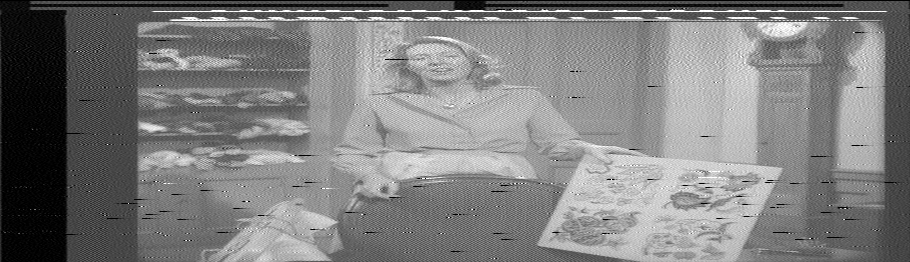

In [193]:
reduced = (field1[0][0] - rfd.iretohz(-40)) / SysParams['hz_ire']
lines16 = np.uint16(np.clip(reduced * (65535 / 140), 0, 65535) + 0.5)

draw_raw_bwimage(lines16, outlinelen, 262, hscale=1, vscale=1)

(425376,)
uint8 (504, 844) (504, 844)


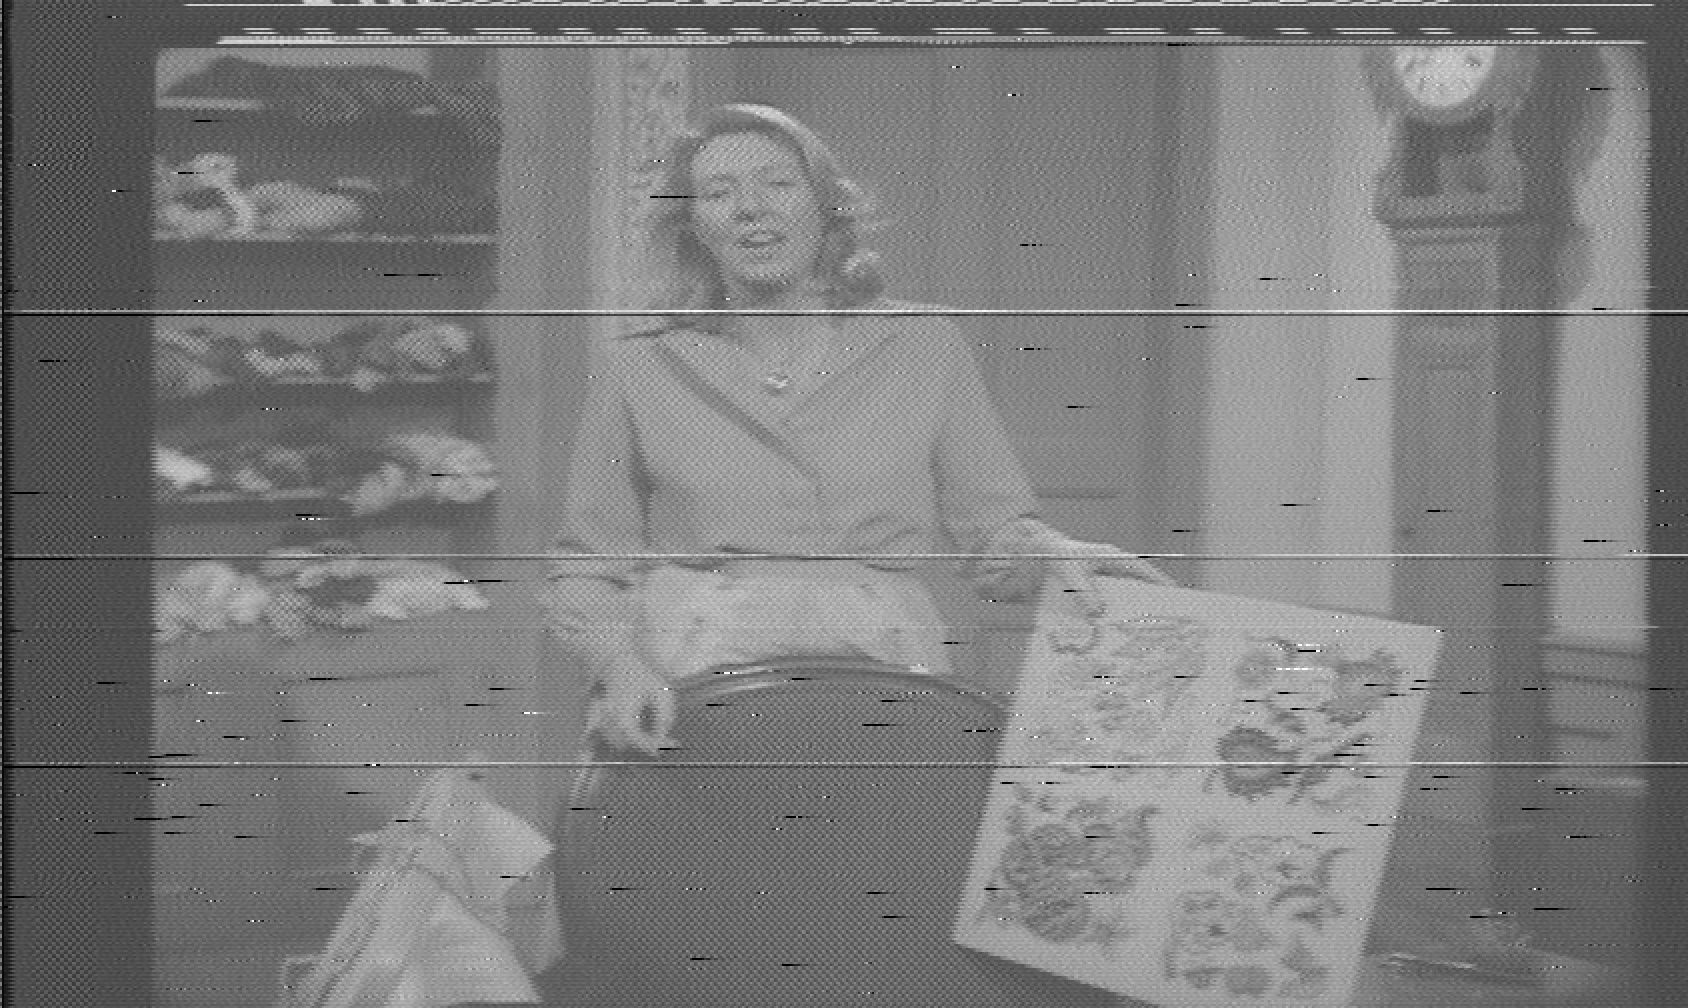

In [194]:
# (mostly the) old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140

hz_ire_scale = 1700000 / 140

# NTSC
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

# This produces an ld-decode comb-ntsc.cxx compatible frame.
def formatoutput(scaledfield1, scaledfield2):
    outwidth = 910

    burstlevel = np.zeros(506, dtype=np.float32)
    
    combined = np.zeros((outwidth * 506), dtype=np.double)
    for i in range(0, 506, 2):
        #print(i)
        fline = 10 + (i // 2)
        combined[((i + 0) * outwidth):((i + 1) * outwidth)] = scaledfield1[0][0][fline * outwidth: (fline + 1) * outwidth]
        combined[((i + 1) * outwidth):((i + 2) * outwidth)] = scaledfield2[0][0][fline * outwidth: (fline + 1) * outwidth]
        
        burstlevel[i] = scaledfield1[1][i // 2]
        burstlevel[i+1] = scaledfield2[1][i // 2]
        
    reduced = (combined - minn) / hz_ire_scale
    lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

    # crop the 16-bit frame down to 844x505 for ld-decode
    
    frameout = np.zeros((844 * 505), dtype=np.uint16)
    offset = 60
    
    for i in range(0, 505):
        # copy the line set
        frameout[(i + 0) * 844: (i + 1) * 844] = lines16[((i + 0) * 910) + offset: ((i + 0) * 910) + 844 + offset]

    for i in range(0, 505):
        if burstlevel[i] > 0:
            frameout[((i + 0) * 844)] = 16384
        else:
            frameout[((i + 0) * 844)] = 32768

        clevel = .5/hz_ire_scale

        frameout[((i + 0) * 844) + 1] = np.uint16(327.67 * clevel * np.abs(burstlevel[i]))
        #print(i, frameout[((i + 0) * 844) + 0], frameout[((i + 0) * 844) + 1])

    return combined, frameout

combined, output_cropped = formatoutput(field1, field2)

outfile = open('tmp.tbc', 'wb')
outfile.write(output_cropped)
draw_raw_bwimage(output_cropped, 844, 504, hscale=2, vscale=2)


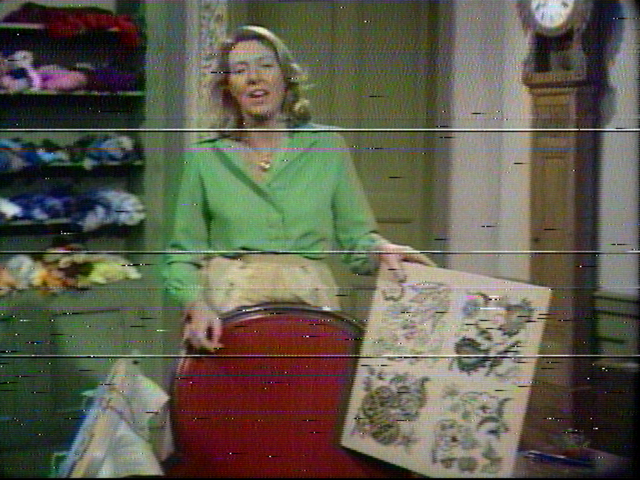

In [195]:
import os
os.system("cat tmp.tbc | ./comb-ntsc -d 2 - > testx.rgb; convert -size 744x480 -depth 16 -resize 200%\! rgb:testx.rgb -resize 640x480\! testx.png")

#from IPython.display import Image
IPython.display.Image("testx.png")

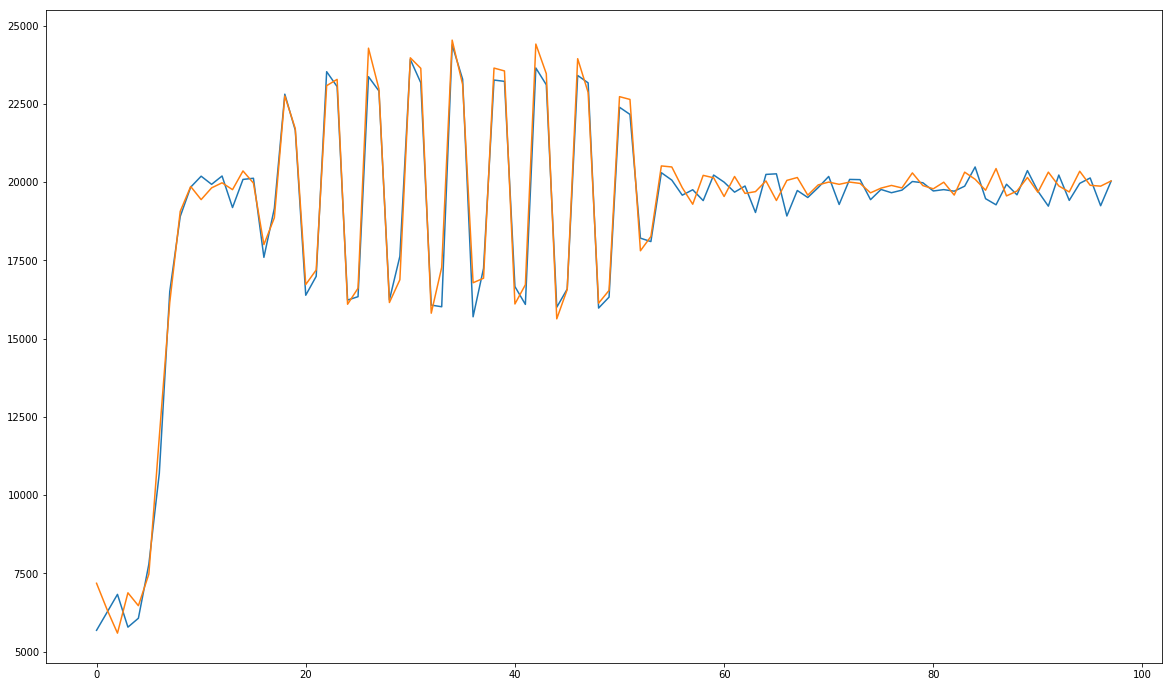

In [209]:
l = 20

bar1 = output_cropped1[(844*l)+2:(844*(l+0))+100]
plt.plot(bar1)

bar0 = output_cropped[(844*l)+2:(844*(l+0))+100]
plt.plot(bar0)



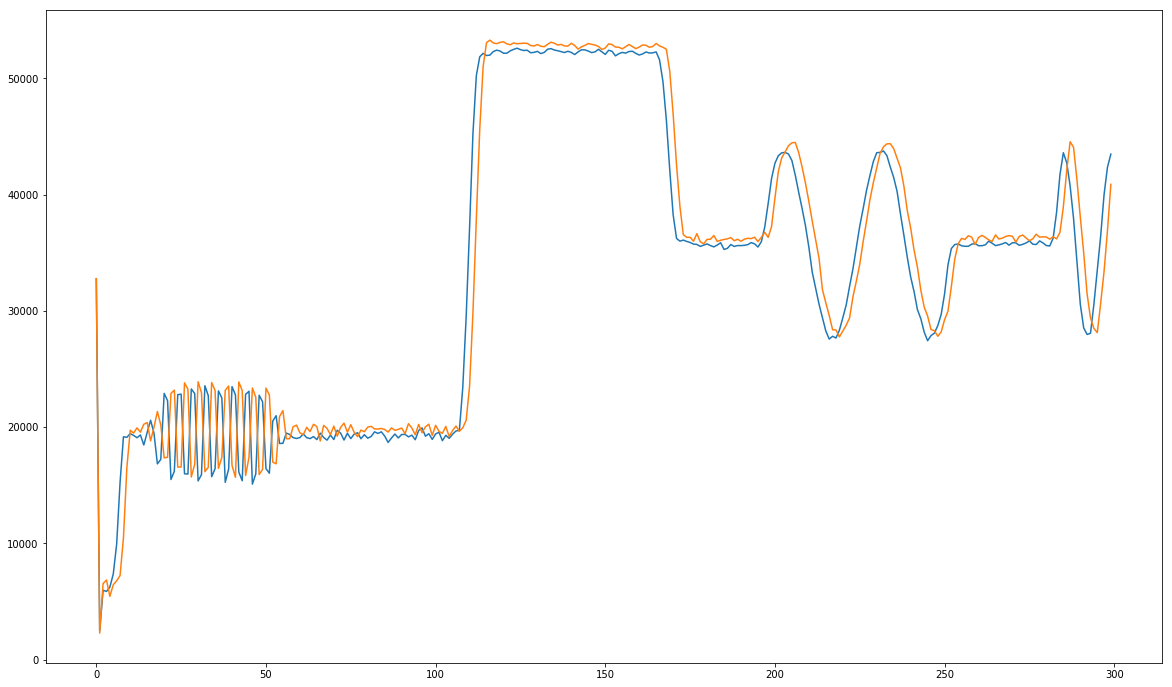

In [166]:
l = 21

bar0 = output_cropped[844*l:(844*(l+0))+300]
plt.plot(bar0)

bar1 = output_cropped1[844*l:(844*(l+0))+300]
plt.plot(bar1)


In [138]:
fd = open('tmp1.tbc', 'rb')
inbuf = fd.read(len(output_cropped) * 2)
output_cropped1 = np.fromstring(inbuf, 'uint16', len(inbuf) // 2)


/home/cpage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [443]:
field1[0][0]

array([0., 0., 0., ..., 0., 0., 0.])

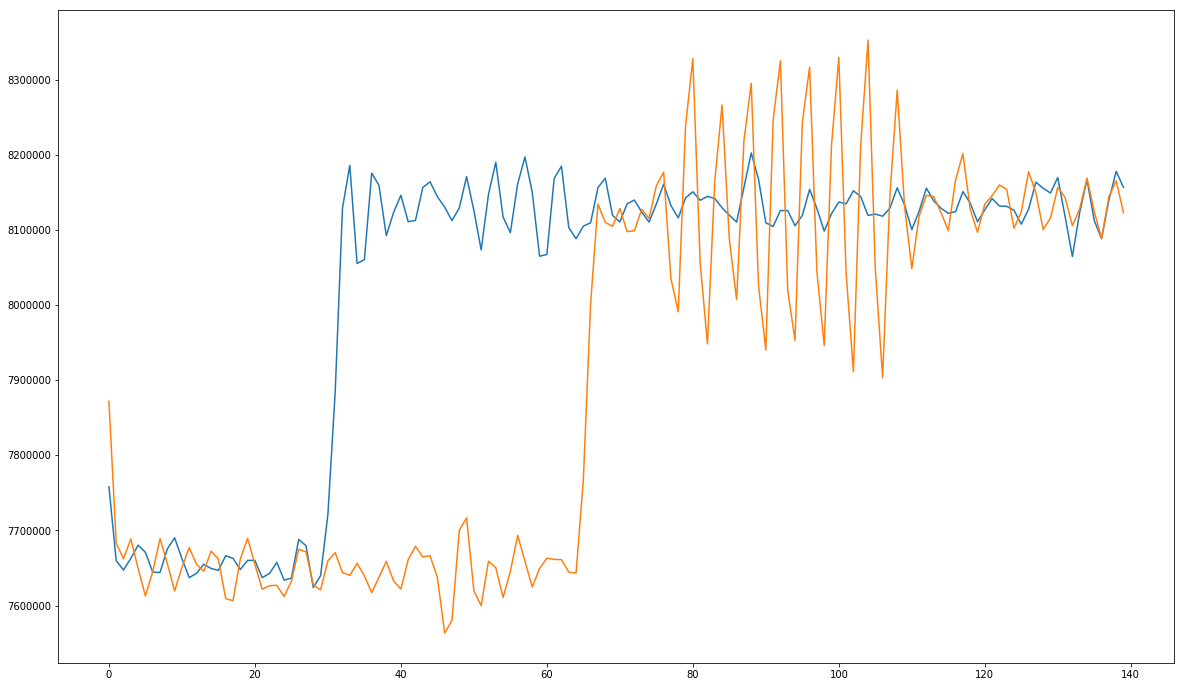

In [74]:
l = 1
plt.plot(decoded_field[0][(outlinelen*l):(outlinelen*(l+0))+140])
l = 11
plt.plot(decoded_field[0][(outlinelen*l):(outlinelen*(l+0))+140])


In [75]:
for l in range(0, 260):
    print(rfd.hztoire(decoded_field[0][(outlinelen*l)+0]))

-667.0588235294117
-28.150069880167
-23.588483451775723
-26.06297070814305
-28.102192657533713
-29.066123839259575
-27.361345285613233
-27.96040283942079
-26.224556075390986
-26.141768066604907
-18.115139021687646
-18.7896810484551
-17.513851476149732
-17.737598041042105
-14.902550706604254
-18.153592950446924
-16.538998030489378
-18.660929724296707
-23.005728780126507
-15.287050752708721
-17.000631856692188
-20.03916891489866
-16.67046957800577
-21.990695434462715
-15.482862329817683
-13.256810037143419
-18.712062737264123
-14.956807200709676
-16.521540154111747
-18.443270999732853
-18.83715038257203
-17.595245389418984
-13.393196270730181
-20.877194293556407
-19.788052234557775
-16.01008963391896
-17.740281923585396
-21.69568600679612
-19.25490399975462
-17.751693566125248
-21.824196279945312
-18.998723137432382
-19.62328636602571
-21.058318483295544
-18.691959312625986
-19.914508053011918
-18.612320996045025
-16.63009264775978
-18.514515055726072
-18.08603986032031
-17.0913038698740

In [560]:
outlinelen = (4 * 1000000 * 315 / 88) / (1000000/SysParams['line_period'])
outlinelen = int(np.round(outlinelen))

rv2 = downscale_field(decode1[0]['demod_burst'], linelocs3, outwidth=outlinelen)

In [601]:
# Return empty if there isn't enough good data before/after the vsync
if len(vsyncs) == 0:
    # return whole field distance
    pass
if len(vsyncs) == 1 or vsyncs[0][1] is None:
    # skip ahead
    # return peaklist[vsyncs[0]]
    pass

In [561]:
linelocs3a = linelocs3.copy()

for l in range(len(linelocs2)):
    ba = rv2[0][outlinelen*l:outlinelen*(l+0)+150].copy()
    ba -= np.mean(ba)
    m = np.argmax(np.abs(ba))

    zc = calczc(ba, m, 0)
    if zc is not None:
        rtgt = (np.round((zc-1)/2)*2)+1
    
        print(l, np.max(np.abs(ba)), calczc(ba, m, 0), rtgt, rtgt - zc)
    
        linelocs3a[l] += (rtgt - zc) * (40 / (4 * 315 / 88))

BUG:  cannot figure out zero crossing for beginning of data
1 211995.05750482783 100.94145584885827 101.0 0.058544151141731504
2 215311.00302130307 102.9761104560903 103.0 0.023889543909703548
3 210719.01860200314 100.92729655458122 101.0 0.0727034454187816
4 207271.6913499124 107.0973513577365 107.0 -0.09735135773649972
5 210930.60127187544 98.98681733381383 99.0 0.013182666186168035
6 217775.4560983924 105.11626651295201 105.0 -0.1162665129520093
7 206774.2326234388 100.91849411787034 101.0 0.0815058821296617
8 197237.37138115172 102.96515305382286 103.0 0.034846946177140126
9 210890.7132522543 100.9651501667555 101.0 0.03484983324449331
10 209776.91423736446 99.01837607608648 99.0 -0.01837607608648284
11 216681.94686175528 100.9830160552087 101.0 0.01698394479130627
12 208874.04682647658 98.9244856349312 99.0 0.07551436506879838
13 221363.5636042922 100.9330157195578 101.0 0.06698428044219895
14 207723.42951815532 98.97080918784062 99.0 0.029190812159384905
15 213549.50077570815 100

232 219580.83206174648 102.93082017058344 103.0 0.0691798294165551
233 220354.51857683048 100.92585714291562 101.0 0.07414285708438229
234 224232.19281682206 98.93110170495167 99.0 0.0688982950483279
235 217098.1491441792 100.95587900200414 101.0 0.044120997995861444
236 231992.37231083534 98.91368513654312 99.0 0.08631486345687733
237 227780.14510190612 100.94635872611913 101.0 0.0536412738808707
238 226608.10120988457 102.924869375118 103.0 0.07513062488199296
239 224440.63198331295 100.94713705636747 101.0 0.05286294363253319
240 214426.86971052384 98.9357888566921 99.0 0.0642111433079009
241 213904.2537599798 100.93863800475455 101.0 0.0613619952454485
242 221515.42580187574 102.91108682436361 103.0 0.08891317563639234
243 222582.72459317336 100.9736966501251 101.0 0.02630334987489391
244 207032.27354080393 98.92935185487707 99.0 0.07064814512293083
245 221518.96104407814 100.93563276639166 101.0 0.06436723360833696
246 217479.66604688484 102.96743183642532 103.0 0.0325681635746804

In [506]:
(np.round((103.37-1)/2)*2)+1

103.0

array([ 163269,  128189, -162149, -127279,  154361,  120564, -148087,
       -116638,  135226,  107517, -123899, -101543,  106251,   90531,
        -91115,  -82641,   70772,   69734,  -54877,  -60636], dtype=int32)

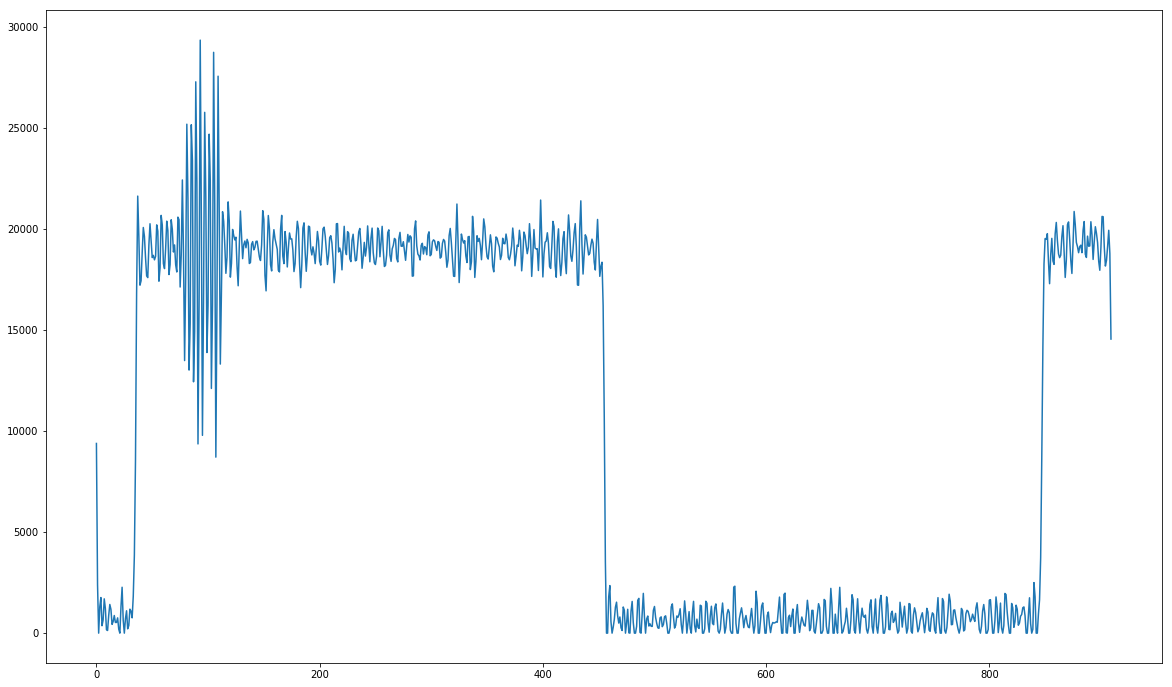

In [388]:
l = 3
plt.plot(lines16[outlinelen*l:outlinelen*(l+1)])

In [17]:
class Framer:
    def __init__(self):
        returna
    
    